In [1]:
from voc_dataset import VOCDetection
from config import opt
import numpy as np
from lib.vgg_model import VGG_SSD
from lib.res_model import RES18_SSD, RES101_SSD
from lib.resnet import *
import torch
import torch.nn.functional as F
import os
from lib.utils import detection_collate 
from lib.multibox_encoder import MultiBoxEncoder
from lib.ssd_loss import MultiBoxLoss
import cv2
from lib.utils import nms
from lib.augmentations import preproc_for_test
import matplotlib.pyplot as plt
from lib.utils import detect
from voc_dataset import VOC_LABELS

%matplotlib inline

In [2]:
VOC_CLASSES = ( 
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')

### load model

In [3]:
model = VGG_SSD(opt.num_classes, opt.anchor_num)
# model = RES18_SSD(opt.num_classes, opt.anchor_num,pretrain=False)
# model = RES101_SSD(opt.num_classes, opt.anchor_num,pretrain=False)

state_dict = torch.load('./weights/vgg_base_aug/loss-646.26.pth', map_location='cpu')
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)



IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### anchors

In [4]:
multibox_encoder = MultiBoxEncoder(opt)

### load and preprocess image

In [5]:
image = 'images/000004.jpg'
src = cv2.imread(image, cv2.IMREAD_COLOR)
image = preproc_for_test(src, opt.min_size, opt.mean)
image = torch.from_numpy(image)

### predict

In [6]:
with torch.no_grad():
    loc, conf = model(image.unsqueeze(0))

### convert torch ----> numpy

In [7]:
loc = loc[0]
conf = conf[0]
conf = F.softmax(conf, dim=1)
conf = conf.numpy()
loc = loc.numpy()

### decode location

In [8]:
decode_loc = multibox_encoder.decode(loc)

### detect

In [9]:
gt_boxes, gt_confs, gt_labels = detect(decode_loc, conf, nms_threshold=0.45, gt_threshold=0.1)

### map locations back to original image

In [10]:
h, w = src.shape[:2]
gt_boxes[:, 0] = gt_boxes[:, 0] * w
gt_boxes[:, 1] = gt_boxes[:, 1] * h
gt_boxes[:, 2] = gt_boxes[:, 2] * w
gt_boxes[:, 3] = gt_boxes[:, 3] * h
gt_boxes = gt_boxes.astype(int)

### show

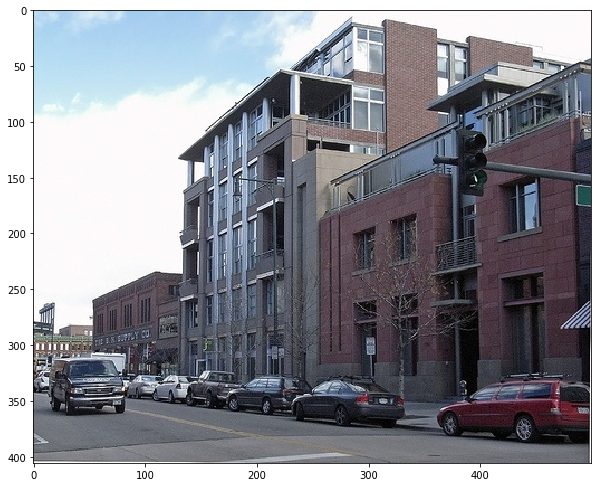

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(src[:, :, ::-1])

6 0.9998061 363 329 498 387
6 0.98989886 10 311 83 362
6 0.9313741 226 328 335 374
6 0.82850915 178 326 247 361
6 0.7483611 136 322 187 357
6 0.52862644 88 325 139 352
6 0.35167125 108 323 170 354
6 0.11381902 463 330 499 386


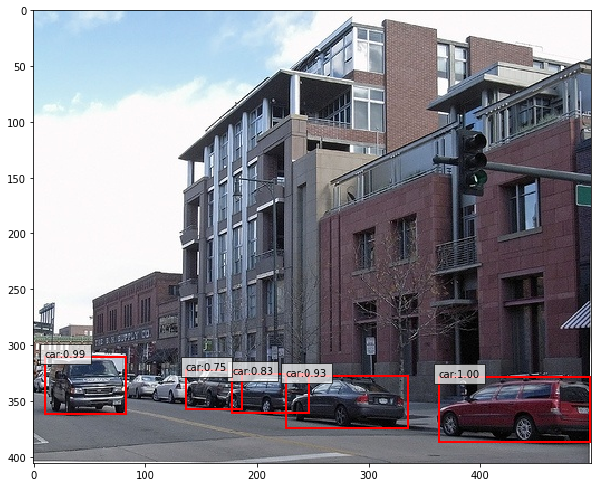

In [12]:
plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.imshow(src[:, :, ::-1])
for box, label, score in zip(gt_boxes, gt_labels, gt_confs):
        print(label, score, *box)
        if score > 0.7:
            text = '{:s}:{:.2f}'.format(VOC_LABELS[label], score)
            ax.add_patch(
                plt.Rectangle(
                (box[0], box[1]), 
                 box[2] - box[0], 
                 box[3] - box[1],
                 fill=False, 
                 edgecolor='red',
                 linewidth=2)
            )
            ax.text(box[0], box[1], text,
                    bbox={'facecolor' : 'white', 'alpha' : 0.7, 'pad' : 5}
                   )
plt.savefig('images/2.jpg')